   # L05a_Artificial Neural Network with Pytorch 
   
   - Developed by **Armin Norouzi**
   - Compatible with Google Colaboratory- Pytorch version 1.12.1+cu113

   
   - **Objective:** Start working with Pytorch from simple example to real-world problem
   
   
** Table of content: **

- Linear Regression with PyTorch
- Neural Network Basic Modeling using PyTorch
- Adavnced ANN Model for Regression
- Adavnced ANN Model for Classification




# Linear Regression with PyTorch

In this section we'll use PyTorch's machine learning model to progressively develop a best-fit line for a given set of data points. Like most linear regression algorithms, we're seeking to minimize the error between our model and the actual data, using a <em>loss function</em> like mean-squared-error.

![img](https://upload.wikimedia.org/wikipedia/commons/e/ed/Residuals_for_Linear_Regression_Fit.png)

Image source: <a href='https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png'>https://commons.wikimedia.org/wiki/File:Residuals_for_Linear_Regression_Fit.png</a>

To start, we'll develop a collection of data points that appear random, but that fit a known linear equation $y = 2x+1$

- Importing libraries

In [1]:
import torch
print(torch.__version__)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# to avoid writing torch.nn
import torch.nn as nn

1.12.1+cu113


## Create data

- create x using linspace and reshape it to -1 to 1 to make it column value

In [2]:
X = torch.linspace(1,50,50).reshape(-1,1)


- Generating output value using random function

In [3]:
torch.manual_seed(71) # to obtain reproducible results
e = torch.randint(-8,9,(50,1),dtype=torch.float)

# adding noise to make our data noisy for modeling
y = 2*X + 1 + e
print(f"X shape is {X.shape} and y shape is {y.shape}")

X shape is torch.Size([50, 1]) and y shape is torch.Size([50, 1])


- Plotting data

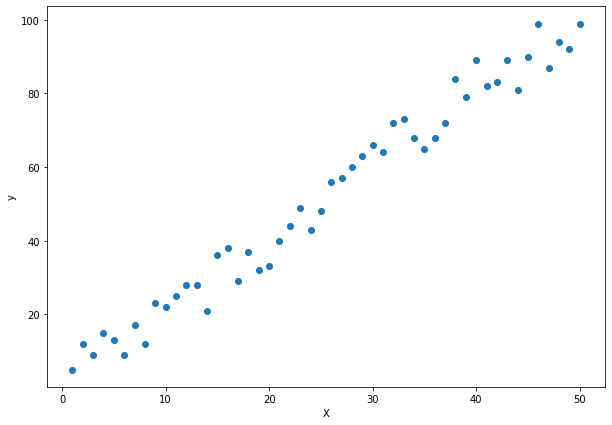

In [4]:
# we cannot plot tensor from torch so we need to convert it to numpy array
plt.figure(figsize=(10, 7))
plt.scatter(X.numpy(), y.numpy())
plt.xlabel('X')
plt.ylabel('y')
plt.show();

## Simple linear model
As a quick demonstration we'll show how the built-in <tt>nn.Linear()</tt> model preselects weight and bias values at random.

In [5]:
# To set a seed in order to get exact same value everytime we run the cell
torch.manual_seed(59)

model = nn.Linear(in_features=1, out_features=1)


print(model.weight)
print(model.bias)

Parameter containing:
tensor([[0.1060]], requires_grad=True)
Parameter containing:
tensor([0.9638], requires_grad=True)


Without seeing any data, the model sets a random weight of 0.1060 and a bias of 0.9638.

### Model classes
PyTorch lets us define models as object classes that can store multiple model layers. In upcoming sections we'll set up several neural network layers, and determine how each layer should perform its forward pass to the next layer. For now, though, we only need a single <tt>linear</tt> layer.

In [6]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

**Note:** The "Linear" model layer used here doesn't really refer to linear regression. Instead, it describes the type of neural network layer employed. Linear layers are also called "fully connected" or "dense" layers. Going forward our models may contain linear layers, convolutional layers, and more.

When <tt>Model</tt> is instantiated, we need to pass in the size (dimensions) of the incoming and outgoing features. For our purposes we'll use (1,1).<br>As above, we can see the initial hyperparameters.

In [7]:
torch.manual_seed(59)
model = Model(1, 1)
print(model)
print('Weight:', model.linear.weight.item())
print('Bias:  ', model.linear.bias.item())

Model(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Weight: 0.10597813129425049
Bias:   0.9637961387634277


As models become more complex, it may be better to iterate over all the model parameters:

In [8]:
for name, param in model.named_parameters():
    print(name, '\t', param.item())

linear.weight 	 0.10597813129425049
linear.bias 	 0.9637961387634277


This is just a random wights and biases as we did not train the model

### Set the loss function
We could write our own function to apply a Mean Squared Error (MSE) that follows<br>

$\begin{split}MSE &= \frac {1} {n} \sum_{i=1}^n {(y_i - \hat y_i)}^2 \\
&= \frac {1} {n} \sum_{i=1}^n {(y_i - (wx_i + b))}^2\end{split}$<br>

Fortunately PyTorch has it built in.<br>
<em>By convention, you'll see the variable name "criterion" used, but feel free to use something like "linear_loss_func" if that's clearer.</em>

In [9]:
criterion = nn.MSELoss()

### Set the optimization
Here we'll use <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>Stochastic Gradient Descent</a> (SGD) with an applied <a href='https://en.wikipedia.org/wiki/Learning_rate'>learning rate</a> (lr) of 0.001. Recall that the learning rate tells the optimizer how much to adjust each parameter on the next round of calculations. Too large a step and we run the risk of overshooting the minimum, causing the algorithm to diverge. Too small and it will take a long time to converge.

For more complicated (multivariate) data, you might also consider passing optional <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum'><tt>momentum</tt></a> and <a href='https://en.wikipedia.org/wiki/Tikhonov_regularization'><tt>weight_decay</tt></a> arguments. Momentum allows the algorithm to "roll over" small bumps to avoid local minima that can cause convergence too soon. Weight decay (also called an L2 penalty) applies to biases.

For more information, see <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a>

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr= 0.001)

### Train the model
An <em>epoch</em> is a single pass through the entire dataset. We want to pick a sufficiently large number of epochs to reach a plateau close to our known parameters of $\mathrm {weight} = 2,\; \mathrm {bias} = 1$

In [11]:
# Set a reasonably large number of passes
epochs = 50

# Create a list to store loss values. This will let us view our progress afterward.
losses = []

for i in range(epochs):
    i += 1

    # Create a prediction set by running "X" through the current model parameters
    y_pred = model.forward(X) 

    # claculating loss function
    loss = criterion(y_pred, y) 

    # Add the loss value to our tracking list
    # as loss coming from criterion we need to detach it and converted it to numpy
    # array in order to plot it later
    losses.append(loss.detach().numpy())

    # Print the current line of results 
    print(f'epoch: {i:2}  loss: {loss.item():10.8f} \
          weight: {model.linear.weight.item():10.8f}  \
          bias: {model.linear.bias.item():10.8f}') 
    
    # Gradients accumulate with every backprop. To prevent compounding we need 
    # to reset the stored gradient for each new epoch.
    optimizer.zero_grad()

    # Now we can backprop
    loss.backward()

    # Finally, we can update the hyperparameters of our model
    optimizer.step()

epoch:  1  loss: 3057.21679688           weight: 0.10597813            bias: 0.96379614
epoch:  2  loss: 1588.53112793           weight: 3.33490038            bias: 1.06046367
epoch:  3  loss: 830.30029297           weight: 1.01483262            bias: 0.99226284
epoch:  4  loss: 438.85241699           weight: 2.68179965            bias: 1.04252183
epoch:  5  loss: 236.76152039           weight: 1.48402119            bias: 1.00766504
epoch:  6  loss: 132.42912292           weight: 2.34460592            bias: 1.03396463
epoch:  7  loss: 78.56572723           weight: 1.72622538            bias: 1.01632178
epoch:  8  loss: 50.75775909           weight: 2.17050409            bias: 1.03025162
epoch:  9  loss: 36.40123367           weight: 1.85124576            bias: 1.02149546
epoch: 10  loss: 28.98922920           weight: 2.08060074            bias: 1.02903891
epoch: 11  loss: 25.16238213           weight: 1.91576838            bias: 1.02487016
epoch: 12  loss: 23.18647385           weight:

### Plot the loss values
Let's see how loss changed over time

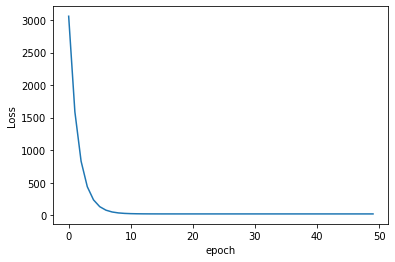

In [12]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

### Plot the result
Now we'll derive <tt>y1</tt> from the new model to plot the most recent best-fit line.

In [13]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Current weight: {w1:.8f}, Current bias: {b1:.8f}')
print()

x1 = np.array([X.min(),X.max()]) 

y1 = x1*w1 + b1

Current weight: 1.98381913, Current bias: 1.05575156



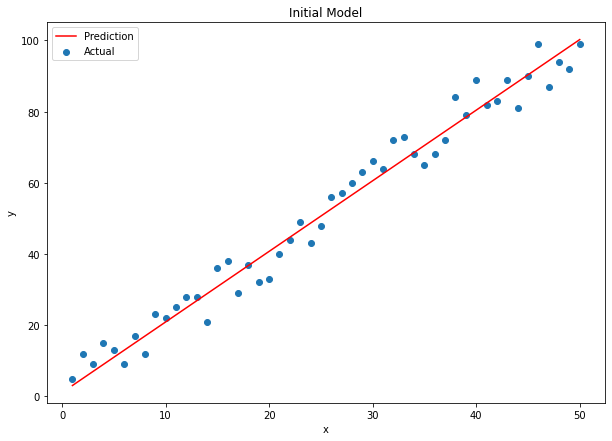

In [14]:
plt.figure(figsize=(10, 7))

plt.scatter(X.numpy(), y.numpy(), label = "Actual")
plt.plot(x1,y1,'r', label = "Prediction")
plt.title('Initial Model')
plt.ylabel('y')
plt.xlabel('x')
plt.legend()
plt.show();

Great job! Model is ready!

# Neural Network Basic Modeling using PyTorch


## Loading iris dataset

Here we'll load the iris flower dataset using `sklearn.datasets` and converted to pandas dataframe

In [15]:
import pandas as pd

from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [16]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Visualizing dataset

The iris dataset has 4 features. To get an idea how they correlate we can plot four different relationships among them.<br>
We'll use the index positions of the columns to grab their names in pairs with <tt>plots = [(0,1),(2,3),(0,2),(1,3)]</tt>.<br>
Here <tt>(0,1)</tt> sets "sepal length (cm)" as <tt>x</tt> and "sepal width (cm)" as <tt>y</tt>

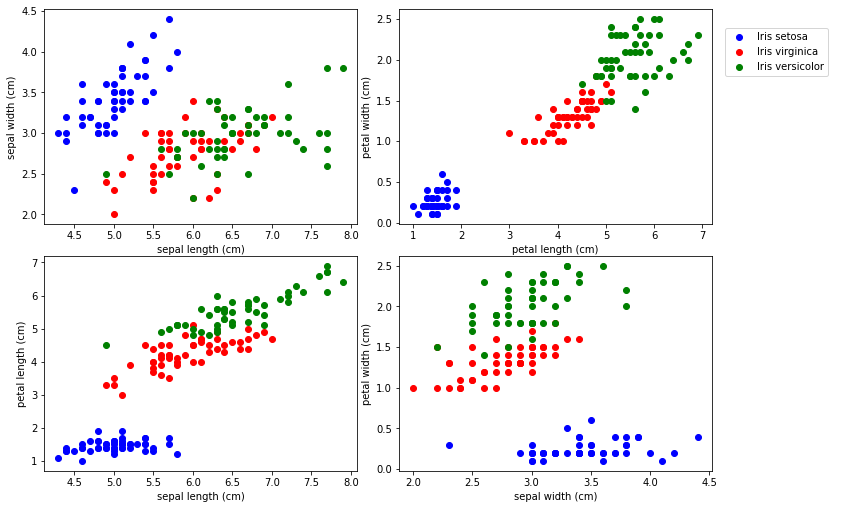

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

The iris dataset consists of 50 samples each from three species of Iris (<em>Iris setosa</em>, <em>Iris virginica</em> and <em>Iris versicolor</em>), for 150 total samples. We have four features (sepal length & width, petal length & width) and three unique labels:
0. <em>Iris setosa</em>
1. <em>Iris virginica</em>
2. <em>Iris versicolor</em>

### The classic method for building train/test split tensors
Before introducing PyTorch's Dataset and DataLoader classes, we'll take a quick look at the alternative.

In [18]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df.drop('target',axis=1).values,
                                                    df['target'].values, test_size=0.2,
                                                    random_state=33)

# Casting traina and test data set to pytorch tensor
X_train = torch.FloatTensor(train_X)
X_test = torch.FloatTensor(test_X)
# y_train = F.one_hot(torch.LongTensor(y_train))  # not needed with Cross Entropy Loss
# y_test = F.one_hot(torch.LongTensor(y_test))
y_train = torch.LongTensor(train_y) 
y_test = torch.LongTensor(test_y)

In [19]:
print(f'Training size: {len(y_train)}')
labels, counts = y_train.unique(return_counts=True)
print(f'Labels: {labels}\nCounts: {counts}')

Training size: 120
Labels: tensor([0, 1, 2])
Counts: tensor([42, 42, 36])


### Using PyTorch's Dataset and DataLoader classes
A far better alternative is to leverage PyTorch's <a href='https://pytorch.org/docs/stable/data.html'><strong><tt>Dataset</tt></strong></a> and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><strong><tt>DataLoader</strong></tt></a> classes.

Usually, to set up a Dataset specific to our investigation we would define our own custom class that inherits from <tt>torch.utils.data.Dataset</tt>. For now, we can use the built-in <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset'><strong><tt>TensorDataset</tt></strong></a> class.

In [20]:
from torch.utils.data import TensorDataset, DataLoader

# Data comming from all columns except target, so we are droping "target"
data = df.drop('target',axis=1).values 
labels = df['target'].values

# TensorDataset to split train and test
iris = TensorDataset(torch.FloatTensor(data),torch.LongTensor(labels))

In [21]:
type(iris)

torch.utils.data.dataset.TensorDataset

Once we have a dataset we can wrap it with a DataLoader. This gives us a powerful sampler that provides single- or multi-process iterators over the dataset. 

Another benifits is to create a shuffle batches

In [22]:
iris_loader = DataLoader(iris, batch_size=32, shuffle=True)

For this analysis we don't need to create a Dataset object, but we should take advantage of PyTorch's DataLoader tool. Even though our dataset is small (120 training samples), we'll load it into our model in two batches. This technique becomes very helpful with large datasets.

Note that scikit-learn already shuffled the source dataset before preparing train and test sets. We'll still benefit from the DataLoader shuffle utility for model training if we make multiple passes throught the dataset.

In [23]:
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)

testloader = DataLoader(X_test, batch_size=60, shuffle=False)

### A Quick Note on Torchvision
PyTorch offers another powerful dataset tool called <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>, which is useful when working with image data. torchvision offers built-in image datasets like <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST</a> and <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a>, as well as tools for transforming images into tensors.

## Create a model class

For this exercise we're using the Iris dataset. Since a single straight line can't classify three flowers we should include at least one hidden layer in our model.

In the forward section we'll use the <a href='https://en.wikipedia.org/wiki/Rectifier_(neural_networks)'>rectified linear unit</a> (ReLU)  function<br>
$\quad f(x)=max(0,x)$<br>
as our activation function. This is available as a full module <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong><tt>torch.nn.ReLU</tt></strong></a> or as just a functional call <a href='https://pytorch.org/docs/stable/nn.html#id27'><strong><tt>torch.nn.functional.relu</tt></strong></a>

In [24]:
import torch.nn.functional as F

In [25]:
from pyparsing.helpers import Forward

class Model(nn.Module):

  def __init__(self, in_features = 4, h1 = 8, h2 = 9, out_features = 3):
      # how many layers?
      # input layer (4 feature) --> h1 N ---> h2 N ---> output(3 classes)
      super().__init__()
      self.fc1 = nn.Linear(in_features, h1)   # input layer
      self.fc2 = nn.Linear(h1, h2)            # hidden layer
      self.out = nn.Linear(h2, out_features)  # output layer

  def forward(self, x):

    x = F.relu(self.fc1(x)) 
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x
      

In forward method, we can use:

```
    a1 = F.relu(self.fc1(x)) 
    a2 = F.relu(self.fc2(a1))
    a3 = self.out(a2)

    return a3
```

But for sake of programming it's easier to use only x

In [26]:
# Instantiate the Model class using parameter defaults:

torch.manual_seed(32)
model = Model()

### Define loss equations and optimizations
As before, we'll utilize <a href='https://en.wikipedia.org/wiki/Cross_entropy'>Cross Entropy</a> with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll use a variation of Stochastic Gradient Descent called <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (short for Adaptive Moment Estimation), with <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [27]:
# in PyTorh you don't need to perform oneHotEncoder as CrossEntropyLoss perform this for us

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

### Train the model

In [28]:
epochs = 100
losses = []

for i in range(epochs):
    i += 1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.detach().numpy())
 
    
    # a neat trick to save screen space: 
    # print only every 10 epochs
    if i % 10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 1.15074503
epoch: 11  loss: 0.93714488
epoch: 21  loss: 0.77962422
epoch: 31  loss: 0.60785323
epoch: 41  loss: 0.39894536
epoch: 51  loss: 0.25249207
epoch: 61  loss: 0.14927694
epoch: 71  loss: 0.10029563
epoch: 81  loss: 0.08100697
epoch: 91  loss: 0.07216039


### Plot the loss function

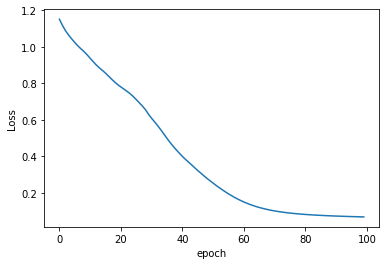

In [29]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

### Validate the model
Now we run the test set through the model to see if the loss calculation resembles the training data.

In [30]:
correct = 0
# no_grad() say pytorch we are not training based on this data and it's only evaluation
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. tensor([-2.1235,  4.8067, -0.8803])     1
 2. tensor([-1.7920,  5.3100, -1.5693])     1
 3. tensor([  6.3723,   0.8741, -10.0971])  0
 4. tensor([-3.9129,  4.5951,  1.1509])     1
 5. tensor([-7.4882,  3.1953,  5.7839])     2
 6. tensor([-10.5202,   1.6381,   9.6291])  2
 7. tensor([  6.3364,   1.0237, -10.1951])  0
 8. tensor([  7.0690,   0.7370, -10.9620])  0
 9. tensor([-7.2218,  3.3422,  5.3528])     2
10. tensor([-9.4170,  2.5675,  8.1028])     2
11. tensor([-9.9029,  2.3388,  8.7141])     2
12. tensor([ 6.2942,  0.6938, -9.8046])     0
13. tensor([-9.3335,  2.1817,  8.1917])     2
14. tensor([-3.7832,  4.5046,  1.0603])     1
15. tensor([-7.8793,  3.0060,  6.2225])     2
16. tensor([-1.8810,  5.1571, -1.3572])     1
17. tensor([-5.7107,  3.5003,  3.6612])     2
18. tensor([  7.2014,   0.7687, -11.1842])  0
19. tensor([-3.2961,  4.7939,  0.3307])     1
20. tensor([-7.7822,  3.7560,  5.7040])     2
21. tensor([  6.6703,   0.8191, -10.4707])  0
22. tensor([  7.4579,   0.9259, -1

## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [31]:
# Saving data
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

Load a new model: We'll load a new model object and test it as we had before to make sure it worked.

In [32]:
new_model = Model()
new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

# Adavnced ANN Model for Regression

The main data set for this section comes from <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a>. In this notebook only reduced version of these data will be used.


In [33]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Loading data

The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this exercise we've whittled the dataset down to just 120,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll show how to calculate distance from GPS coordinates, and how to create a pandas datatime object from a text column. This will let us quickly get information like day of the week, am vs. pm, etc.

Let's get started!

In [34]:
df = pd.read_csv('https://raw.githubusercontent.com/arminnorouzi/machine_learning_course_UofA_MECE610/main/Data/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [35]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

As this is a fare calculation, giving GPS longitudes and latitudes cannot gives us good feature. Instead, we can calculate distance between these two point. Let' do some feature engineering. 

## Feature Engineering

### Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [36]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """Calculates the haversine distance between 2 sets of GPS coordinates in df

    Arg:
        lat1 (str): latitudes column name of point 1 in df
        lat2 (str): latitudes column name of point 2 in df
        long1 (str): longitudes column name of point 1 in df
        long2 (str): longitudes column name of point 2 in df

    return:
        d (float): Traveled distance
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    # Converting to radians
    delta_phi = np.radians(df[lat2] - df[lat1])
    delta_lambda = np.radians(df[long2] - df[long1])
     
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = (r * c) # in kilometers

    return d

In [37]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


### Add a datetime column and derive useful statistics

Date time in origina data base is just an object, let change to date time. Then we can extract information of time and date!

By creating a datetime object, we can extract information like "day of the week", "am vs. pm" etc. Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [39]:
# Change time to EST from UTC --> EDT: Eastern Day Time
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours = 4) 
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour'] < 12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
# df['Weekday'] = df['EDTdate'].dt.dayofweek # Give the integer of day of the week
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


### Handling categorical from continuous columns

We need to handle catagorical columns and continouous colums

In [40]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [41]:
# categorical columns
cat_cols = ['Hour', 'AMorPM', 'Weekday'] 

# continuous columns
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 
             'dropoff_longitude', 'passenger_count', 'dist_km'] 

# this column contains the labels - continuous as we are working on regression problem
y_col = ['fare_amount']  

Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [42]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [43]:
df['AMorPM']

0         am
1         am
2         am
3         pm
4         pm
          ..
119995    am
119996    am
119997    pm
119998    am
119999    pm
Name: AMorPM, Length: 120000, dtype: category
Categories (2, object): ['am', 'pm']

Now it is in catagory format!

We can access the category names with `Series.cat.categories` or just the codes with `Series.cat.codes`. This will make more sense if we look at `df['AMorPM']`:

In [44]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [45]:
df['AMorPM'].cat.codes

0         0
1         0
2         0
3         1
4         1
         ..
119995    0
119996    0
119997    1
119998    0
119999    1
Length: 120000, dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [46]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

# stacking hr ampm wkdy 
cats = np.stack([hr, ampm, wkdy], 1)

# printing first 5 elements
cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

<div class="alert alert-info"><strong>NOTE:</strong> This can be done in one line of code using a list comprehension:
<pre style='background-color:rgb(217,237,247)'>cats = np.stack([df[col].cat.codes.values for col in cat_cols], 1)</pre>

Don't worry about the dtype for now, we can make it int64 when we convert it to a tensor.</div>


### Convert numpy arrays to tensors

In [47]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [48]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [49]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [50]:
print(f" Catagorical data {cats.shape}, continuous data {conts.shape}, and label size {y.shape}")

 Catagorical data torch.Size([120000, 3]), continuous data torch.Size([120000, 6]), and label size torch.Size([120000, 1])


### Set an embedding size

The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.


A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.

- It's actually similar to one hot encoder

In [51]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

e.g., 24 is number of catagory an 12 is embedding dimention!

Let's see this embedding modoule with more detials

**Note:** This is only for illustration purpose and actuall embedding step will be defined inside model class

In [52]:
# This is our source data
catz = cats[:4]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3]])

In [53]:
# This is assigned inside the __init__() method
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [54]:
list(enumerate(selfembeds))

[(0, Embedding(24, 12)), (1, Embedding(2, 1)), (2, Embedding(7, 4))]

In [55]:
# This happens inside the forward() method
embeddingz = []
for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[ 0.8812, -0.2986, -0.4993,  0.2898,  0.1067,  0.3755, -1.0001, -0.0795,
          -1.0229,  0.4145, -0.6683, -0.1413],
         [-1.2164, -0.3969,  0.1169,  0.7550, -0.9323, -0.7374, -1.1504,  0.5753,
          -0.0500, -1.5709, -0.0622, -0.6130],
         [-0.0196,  0.6569,  0.4230, -0.5720,  0.8545,  0.9287, -0.6364, -0.1866,
          -1.7214,  2.5858, -0.8956, -1.2465],
         [-0.8339, -0.1020,  0.4001,  0.9468,  0.4485, -0.4228,  0.5252,  0.4847,
          -0.2217,  0.8438,  1.9616,  0.0604]], grad_fn=<EmbeddingBackward0>),
 tensor([[-1.0521],
         [-1.0521],
         [-1.0521],
         [ 0.9878]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.7652, -0.6659,  0.3488,  0.1225],
         [-0.0318,  0.2763, -1.3599,  0.9068],
         [-0.0318,  0.2763, -1.3599,  0.9068],
         [-0.1288,  2.2813, -0.3463, -0.2203]], grad_fn=<EmbeddingBackward0>)]

In [56]:
# We concatenate the embedding sections (12,1,4) into one (17)
z = torch.cat(embeddingz, 1)
z

tensor([[ 0.8812, -0.2986, -0.4993,  0.2898,  0.1067,  0.3755, -1.0001, -0.0795,
         -1.0229,  0.4145, -0.6683, -0.1413, -1.0521,  0.7652, -0.6659,  0.3488,
          0.1225],
        [-1.2164, -0.3969,  0.1169,  0.7550, -0.9323, -0.7374, -1.1504,  0.5753,
         -0.0500, -1.5709, -0.0622, -0.6130, -1.0521, -0.0318,  0.2763, -1.3599,
          0.9068],
        [-0.0196,  0.6569,  0.4230, -0.5720,  0.8545,  0.9287, -0.6364, -0.1866,
         -1.7214,  2.5858, -0.8956, -1.2465, -1.0521, -0.0318,  0.2763, -1.3599,
          0.9068],
        [-0.8339, -0.1020,  0.4001,  0.9468,  0.4485, -0.4228,  0.5252,  0.4847,
         -0.2217,  0.8438,  1.9616,  0.0604,  0.9878, -0.1288,  2.2813, -0.3463,
         -0.2203]], grad_fn=<CatBackward0>)

In [57]:
# This was assigned under the __init__() method
selfembdrop = nn.Dropout(.4)
z = selfembdrop(z)
z

tensor([[ 1.4687, -0.4977, -0.0000,  0.4831,  0.0000,  0.6259, -0.0000, -0.1325,
         -1.7049,  0.0000, -1.1139, -0.2355, -1.7536,  1.2753, -0.0000,  0.5813,
          0.2041],
        [-0.0000, -0.6614,  0.0000,  1.2584, -0.0000, -1.2291, -1.9173,  0.9589,
         -0.0834, -0.0000, -0.0000, -0.0000, -0.0000, -0.0530,  0.4605, -0.0000,
          1.5113],
        [-0.0327,  0.0000,  0.7050, -0.9533,  0.0000,  0.0000, -1.0607, -0.0000,
         -2.8691,  0.0000, -0.0000, -2.0775, -0.0000, -0.0530,  0.4605, -0.0000,
          1.5113],
        [-0.0000, -0.1699,  0.6668,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
         -0.3696,  1.4064,  3.2694,  0.1006,  1.6463, -0.2147,  3.8021, -0.0000,
         -0.0000]], grad_fn=<MulBackward0>)

This is how the categorical embeddings are passed into the layers.

## Define a TabularModel
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). For this exercise our output will be a single regression value. Note that we'll assume our data contains both categorical and continuous data. You can add boolean parameters to your own model class to handle a variety of datasets.

In [58]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p = 0.5):
        '''Extend the base Module class, set up the following parameters:
            
            emb_szs (list of tuples): each categorical variable size is paired with an embedding size
            n_cont (int): number of continuous variables
            out_sz (int): output size
            layers (list of ints): layer sizes
            p (float) dropout probability for each layer (for simplicity we'll use the same value throughout)
        '''
        super().__init__()

        # Set up the embedded layers with torch.nn.ModuleList() and torch.nn.Embedding()
        # Categorical data will be filtered through these Embeddings in the forward section.
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])

        # Set up a dropout function for the embeddings with torch.nn.Dropout() The default p-value=0.5
        self.emb_drop = nn.Dropout(p)

        # Set up a normalization function for the continuous variables with torch.nn.BatchNorm1d()
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Set up a sequence of neural network layers where each level includes a Linear function, 
        # an activation function (we'll use ReLU), a normalization step, and a dropout layer. 
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))

        # We'll combine the list of layers with torch.nn.Sequential()  
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Define the forward method. Preprocess the embeddings and normalize the continuous variables
        # before passing them through the layers.
        # Use torch.cat() to combine multiple tensors into one.
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        # combining catagorical and continuouse
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [59]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Define loss function & optimizer
PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

In [60]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Perform train/test splits
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [61]:
batch_size = 60000
test_size = int(batch_size * .2)


cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [62]:
print(f"Size of cat size data {len(cat_train)} and Size of cat size data {len(con_train)}")

Size of cat size data 48000 and Size of cat size data 48000


## Train the model


In [63]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss.detach().numpy())
    
    # a neat trick to save screen space:
    if i % 25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.56630707
epoch:  26  loss: 10.90917110
epoch:  51  loss: 10.22225380
epoch:  76  loss: 9.74414921
epoch: 101  loss: 9.18560123
epoch: 126  loss: 8.43061161
epoch: 151  loss: 7.42752314
epoch: 176  loss: 6.22777510
epoch: 201  loss: 5.07439518
epoch: 226  loss: 4.20861053
epoch: 251  loss: 3.89443040
epoch: 276  loss: 3.78748941
epoch: 300  loss: 3.71158195

Duration: 219 seconds


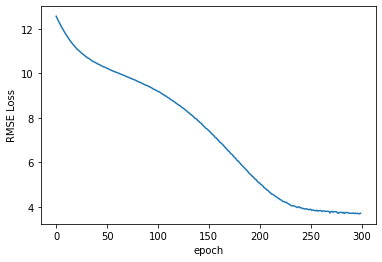

In [64]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

### Validate the model
Here we want to run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [65]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.68012857


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [66]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.2307   2.9000   1.3307
 2.  25.8106   5.7000  20.1106
 3.   5.7241   7.7000   1.9759
 4.  13.7580  12.5000   1.2580
 5.   5.0773   4.1000   0.9773
 6.   4.8525   5.3000   0.4475
 7.   5.3771   3.7000   1.6771
 8.  12.5225  14.5000   1.9775
 9.   3.8871   5.7000   1.8129
10.  10.1222  10.1000   0.0222
11.   3.7874   4.5000   0.7126
12.   3.8549   6.1000   2.2451
13.   6.5111   6.9000   0.3889
14.  14.1740  14.1000   0.0740
15.   5.0504   4.5000   0.5504
16.  26.5452  34.1000   7.5548
17.   5.0162  12.5000   7.4838
18.   2.7109   4.1000   1.3891
19.  12.2830   8.5000   3.7830
20.   6.0526   5.3000   0.7526
21.  12.5935  11.3000   1.2935
22.   9.2388  10.5000   1.2612
23.  15.2013  15.3000   0.0987
24.  15.6251  14.9000   0.7251
25.  36.4187  49.5700  13.1513
26.   4.1442   5.3000   1.1558
27.   3.9157   3.7000   0.2157
28.   7.6288   6.5000   1.1288
29.  14.0077  14.1000   0.0923
30.   5.1799   4.9000   0.2799
31.   6.0204   3.7000   2.3204
32.  39.

### Save the model
We can save a trained model to a file in case we want to come back later and feed new data through it. The best practice is to save the state of the model (weights & biases) and not the full definition. Also, we want to ensure that only a trained model is saved, to prevent overwriting a previously saved model with an untrained one.<br>For more information visit <a href='https://pytorch.org/tutorials/beginner/saving_loading_models.html'>https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>

In [67]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

### Loading a saved model (starting from scratch)
We can load the trained weights and biases from a saved model. If we've just opened the notebook, we'll have to run standard imports and function definitions. To demonstrate, restart the kernel before proceeding.

In [68]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

def haversine_distance(df, lat1, long1, lat2, long2):
    r = 6371
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c

class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

Now define the model. Before we can load the saved settings, we need to instantiate our TabularModel with the parameters we used before (embedding sizes, number of continuous columns, output size, layer sizes, and dropout layer p-value). 

In [69]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

Once the model is set up, loading the saved settings is a snap.

In [70]:
model2.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
model2.eval() # be sure to run this step!

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

Next we'll define a function that takes in new parameters from the user, performs all of the preprocessing steps above, and passes the new data through our trained model.

In [71]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    dfx['dist_km'] = haversine_distance(dfx,'pickup_latitude', 'pickup_longitude',
                                        'dropoff_latitude', 'dropoff_longitude')
    dfx['EDTdate'] = pd.to_datetime(dfx['EDTdate'])
    
    # We can skip the .astype(category) step since our fields are small,
    # and encode them right away
    dfx['Hour'] = dfx['EDTdate'].dt.hour
    dfx['AMorPM'] = np.where(dfx['Hour']<12,0,1) 
    dfx['Weekday'] = dfx['EDTdate'].dt.strftime("%a")
    dfx['Weekday'] = dfx['Weekday'].replace(['Fri','Mon','Sat','Sun','Thu','Tue','Wed'],
                                            [0,1,2,3,4,5,6]).astype('int64')
    # CREATE CAT AND CONT TENSORS
    cat_cols = ['Hour', 'AMorPM', 'Weekday']
    cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                 'dropoff_longitude', 'passenger_count', 'dist_km']
    xcats = np.stack([dfx[col].values for col in cat_cols], 1)
    xcats = torch.tensor(xcats, dtype=torch.int64)
    xconts = np.stack([dfx[col].values for col in cont_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [72]:
z = test_data(model2)

What is the pickup latitude?  40
What is the pickup longitude? -73
What is the dropoff latitude?  40
What is the dropoff longitude? -73.9
How many passengers? 1
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-16 16:04:00

The predicted fare amount is $122.33


# Adavnced ANN Model for Classification

All the feature engineering steps are same and the only diffferent is output layer:


In [73]:
torch.manual_seed(33)
model_classification = TabularModel(emb_szs, conts.shape[1], 2, [200,100], p=0.4) # out_sz = 2

In [74]:
model_classification

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

## Data processing 

Only we need to change labels:

In [75]:
y_col_classification = ['fare_class']  # this column contains the labels
y_classification = torch.tensor(df[y_col_classification].values).flatten()


batch_size = 60000
test_size = 12000

cat_train_classification = cats[:batch_size-test_size]
cat_test_classification = cats[batch_size-test_size:batch_size]
con_train_classification = conts[:batch_size-test_size]
con_test_classification = conts[batch_size-test_size:batch_size]


y_train_classification = y_classification[:batch_size-test_size]
y_test_classification = y_classification[batch_size-test_size:batch_size]

## Define loss function & optimizer
For our classification we'll replace the MSE loss function with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll continue to use <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [76]:
criterion_classification = nn.CrossEntropyLoss()
optimizer_classification = torch.optim.Adam(model_classification.parameters(), lr=0.001)

## Train the model

In [77]:
import time
start_time = time.time()

epochs = 300
losses_classification = []

for i in range(epochs):
    i += 1
    y_pred = model_classification(cat_train_classification, con_train_classification)
    loss = criterion_classification(y_pred, y_train_classification)
    losses_classification.append(loss.detach().numpy())
    
    # a neat trick to save screen space:
    if i % 25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer_classification.zero_grad()
    loss.backward()
    optimizer_classification.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.83367878
epoch:  26  loss: 0.37780651
epoch:  51  loss: 0.33248058
epoch:  76  loss: 0.31617391
epoch: 101  loss: 0.30323014
epoch: 126  loss: 0.29322413
epoch: 151  loss: 0.28523707
epoch: 176  loss: 0.28093061
epoch: 201  loss: 0.27807826
epoch: 226  loss: 0.27105919
epoch: 251  loss: 0.26626557
epoch: 276  loss: 0.26198047
epoch: 300  loss: 0.25747591

Duration: 258 seconds


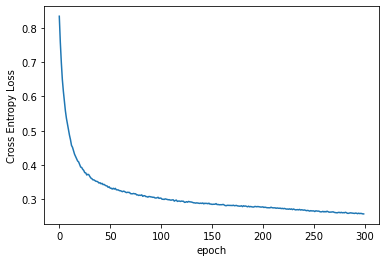

In [78]:
plt.plot(range(epochs), losses_classification)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

### Validate the model

In [79]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model_classification(cat_test_classification, con_test_classification)
    loss = criterion_classification(y_val, y_test_classification)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.25239539


In [93]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test_classification[i]:^7}')
    if y_val[i].argmax().item() == y_test_classification[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([ 2.3041, -0.9639])    0      0   
tensor([-3.8945,  3.2829])    1      0   
tensor([ 2.1981, -1.2288])    0      0   
tensor([-1.7514,  0.9344])    1      1   
tensor([ 2.9590, -1.2309])    0      0   
tensor([ 1.2643, -2.0299])    0      0   
tensor([ 2.5265, -1.4500])    0      0   
tensor([-5.1140,  1.6306])    1      1   
tensor([ 1.3398, -2.8778])    0      0   
tensor([-1.0744,  1.3465])    1      1   
tensor([ 1.1853, -1.8785])    0      0   
tensor([ 3.1559, -0.9703])    0      0   
tensor([ 1.7308, -1.3706])    0      0   
tensor([-1.9807,  0.6394])    1      1   
tensor([ 1.7491, -2.0355])    0      0   
tensor([-3.5733,  1.2019])    1      1   
tensor([ 1.4907, -2.4844])    0      1   
tensor([ 1.8228, -2.1706])    0      0   
tensor([ 0.9647, -0.4620])    0      0   
tensor([ 2.2915, -1.7353])    0      0   
tensor([-2.5675,  0.2103])    1      1   
tensor([-1.5390,  0.2480])    1      1   
tensor([-2.0958,  0.4448])    1   

## References: 

- [PyTorch for Deep Learning with Python Bootcamp](https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/) by [Jose Marcial Portilla](https://www.linkedin.com/in/jmportilla/)